### importación de las librerias a usar

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
import ast

# 0: Análisis exploratorio de datos (EDA)

### Lectura del dataset con Pandas

In [2]:

ruta_archivo = '../data/new_items_dataset.csv'
df = pd.read_csv(ruta_archivo)

C:\Users\linam\AppData\Local\Temp\ipykernel_21860\336152042.py:2: DtypeWarning: Columns (10,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo)


In [3]:
len(df)

100000

#### Histograma para verificar que variable se ajusta más a ser la variable objetivo del modelo

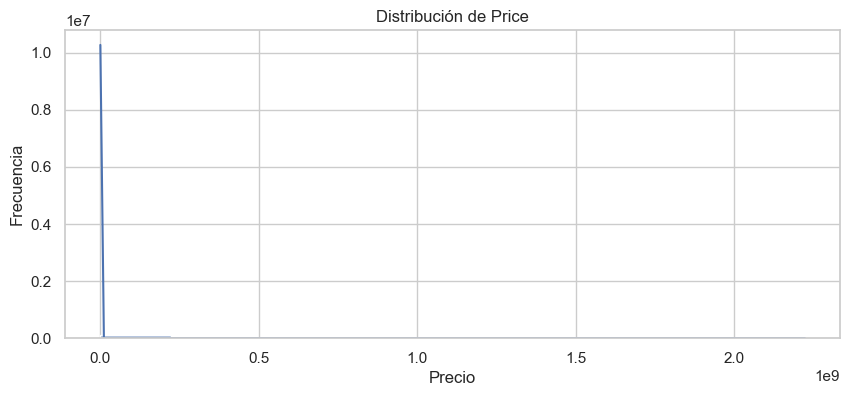

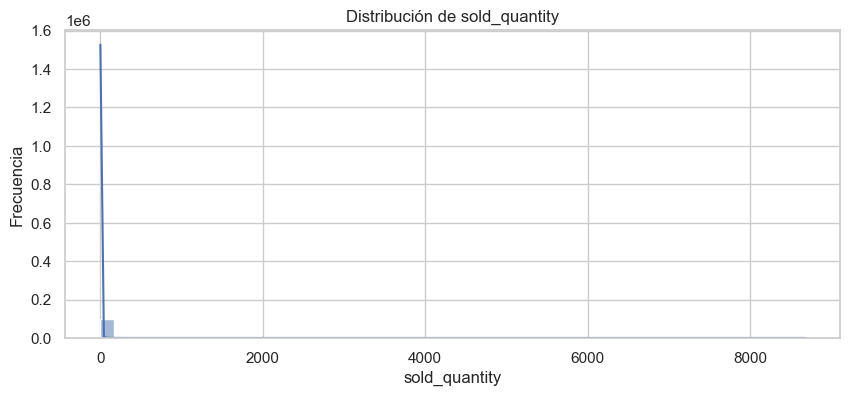

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ajustes generales de estilo
sns.set(style="whitegrid")

# Histograma de 'price'
plt.figure(figsize=(10, 4))
sns.histplot(df['price'], bins=10, kde=True)
plt.title('Distribución de Price')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()

# Histograma de 'sold_quantity'
plt.figure(figsize=(10, 4))
sns.histplot(df['sold_quantity'], bins=50, kde=True)
plt.title('Distribución de sold_quantity')
plt.xlabel('sold_quantity')
plt.ylabel('Frecuencia')
plt.show()

#### Como las variables están altamente sesgadas hacia el 0 se procede a filtrar algunos outliers para el precio y el país (dado que el precio no está claro si está dado en alguna moneda particular), por esto se tomarán los precios menores a 10000 y las filas de las que el país del vendedor sea Argentina que es la mayoría del df

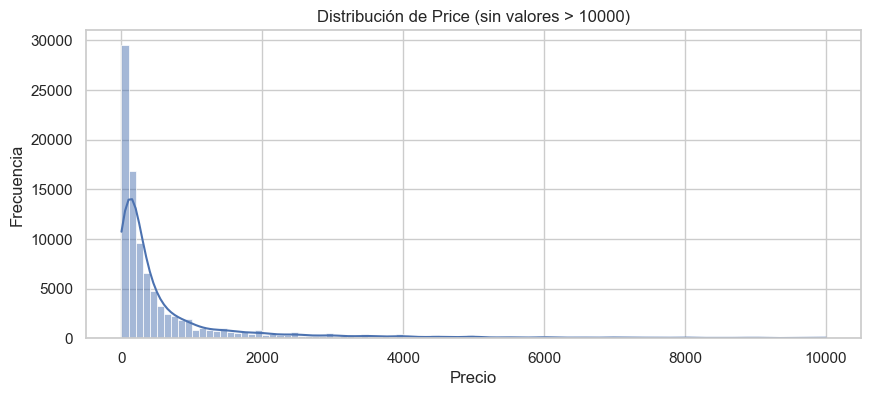

In [5]:

df_argentina = df[df['seller_country'] == 'Argentina']
df_filtrado = df_argentina[df_argentina['price'] <= 10_000]

# Volver a graficar el histograma de price sin outliers
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 4))
sns.histplot(df_filtrado['price'], bins=100, kde=True)
plt.title('Distribución de Price (sin valores > 10000)')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()


#### Se verifica una distribución mejor balanceada para la variable precio.

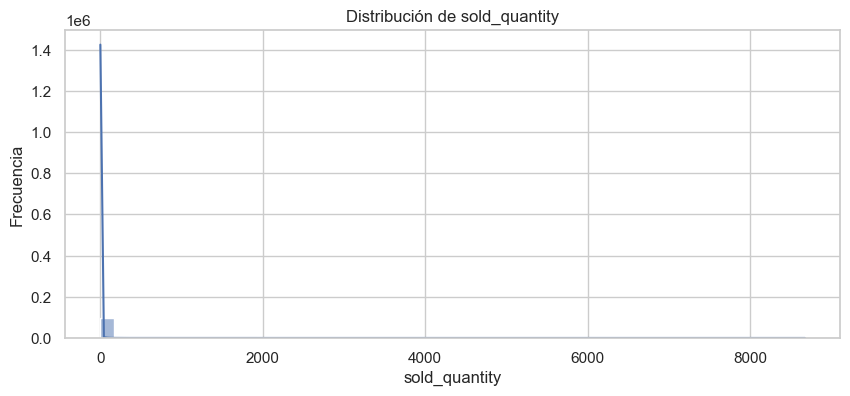

In [6]:
plt.figure(figsize=(10, 4))
sns.histplot(df_filtrado['sold_quantity'], bins=50, kde=True)
plt.title('Distribución de sold_quantity')
plt.xlabel('sold_quantity')
plt.ylabel('Frecuencia')
plt.show()

##### Con el histograma de arriba se verifica que aun filtrando como se dijo más arriba la columna sold_quality no es una buena variable objetivo a menos que se discretice. 

In [7]:
# Estadísticas descriptivas
print(df_filtrado['sold_quantity'].describe())

# Valores únicos ordenados
print("Valores únicos más frecuentes:")
print(df_filtrado['sold_quantity'].value_counts().sort_index().head(20)) 

# Cuántos ceros hay
ceros = (df_filtrado['sold_quantity'] == 0).sum()
print(f'Cantidad de productos con 0 unidades vendidas: {ceros}')
print(f'Porcentaje de ceros: {ceros / len(df_filtrado) * 100:.2f}%')


count    96041.000000
mean         2.485595
std         43.549101
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       8676.000000
Name: sold_quantity, dtype: float64
Valores únicos más frecuentes:
sold_quantity
0.0     79348
1.0      6460
2.0      2468
3.0      1331
4.0       941
5.0       663
6.0       508
7.0       389
8.0       306
9.0       276
10.0      261
11.0      201
12.0      183
13.0      148
14.0      133
15.0      131
16.0      107
17.0       85
18.0      105
19.0       96
Name: count, dtype: int64
Cantidad de productos con 0 unidades vendidas: 79348
Porcentaje de ceros: 82.62%


##### Vemos que el 82% de los valores de ventas son 0, luego no tenemos datos balanceados para que el modelo prediga la variable. Y si hacemos un claificador de ventas (si vende/ no vende) tendríamos una muestra altamente desbalanceada.

In [8]:
# Estadísticas descriptivas
print(df_filtrado['price'].describe())



count    96041.000000
mean       761.437883
std       1418.625975
min          0.840000
25%         89.800000
50%        229.000000
75%        690.000000
max      10000.000000
Name: price, dtype: float64


##### Como se puede observar la variable precio está mucho mejor balanceada, por lo tanto se tomará esta como variable objetivo.
Además el modelo se entrenará y se usará para publicaciones en Argentina.

In [9]:
print("\nInformación general del dataset (tipos de datos, valores no nulos):")
df_argentina.info()

# --- 3. Estadísticas Descriptivas Básicas ---
print("\nEstadísticas descriptivas para columnas numéricas:")
print(df_argentina.describe().T)

print("\nEstadísticas descriptivas para columnas de objetos (categóricas):")
print(df_argentina.describe(include='object').T)



Información general del dataset (tipos de datos, valores no nulos):
<class 'pandas.core.frame.DataFrame'>
Index: 99989 entries, 0 to 99999
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      99989 non-null  object 
 1   title                   99989 non-null  object 
 2   date_created            99989 non-null  object 
 3   base_price              99989 non-null  float64
 4   price                   99989 non-null  float64
 5   category_id             99989 non-null  object 
 6   tags                    99989 non-null  object 
 7   attributes              99989 non-null  object 
 8   variations              99989 non-null  object 
 9   pictures                99989 non-null  object 
 10  seller_id               99989 non-null  object 
 11  seller_country          99989 non-null  object 
 12  seller_province         99989 non-null  object 
 13  seller_city             999

# 1: Feature Engineering

## Observaciones y decisiones.

### Eliminación de columnas:
-La columna **sub_status** tiene 99014 valores faltantes, luego se eliminará la columna.               
-La columna **attributes** tiene 88% de valores faltantes y **variations** el 92% y no se ve ninguna relación con el precio de venta.                
-Como solo se tomaron datos de Argentina se eliminará la columna **seller_country** se dejará **selelr_province** que tiene solo 26 valores posibles y se eliminará **seller_city** que tiene muchos valores distintos y es dificil de codificar.             
-La columna **warranty** tiene un 61% de valores faltantes y mas de 10000 valores diferentes. Es parece una entrada libre del usuario por lo que tampoco se puede codear en tiempos de garantía por lo tanto será una columna eliminada.        

### Otras decisiones:
-Se hará la diferencia entre **base_price** para verificar si en la mayoría de los casos son iguales, en ese caso se tomaría como target una de las dos y la otra no estaría dentro de los features.
-Para la columna **pictures** se sacará la cantidad de fotos del producto y este se tomará como feature.


In [10]:
columnas_a_eliminar = [
    'sub_status', 
    'attributes', 
    'variations', 
    'seller_country', 
    'seller_city', 
    'warranty'
]

df = df_argentina.drop(columns=columnas_a_eliminar, errors='ignore')

In [11]:
# Diferencia entre base_price y price
df['price_diff'] = df['price'] - df['base_price']

# Cantidad de imágenes
import ast
df['picture_count'] = df['pictures'].apply(lambda x: len(ast.literal_eval(x)) if isinstance(x, str) and x.startswith('[') else 0)


In [12]:
print(df['price_diff'].describe())

count    99989.000000
mean         0.099581
std         21.240884
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       6584.000000
Name: price_diff, dtype: float64


In [13]:
porcentaje_ceros = (df['price_diff'] == 0).mean() * 100
print(f"Porcentaje de valores 0 en price_diff: {porcentaje_ceros:.2f}%")

Porcentaje de valores 0 en price_diff: 99.97%


Como 99% de los datos no tienen diferencia entre **price** y **base_price** se tomarán ambas como columnas objetivo del modelo como una sola **price** 

In [14]:
columnas_a_eliminar = [
    'base_price',
    'pictures',
    'price_diff'
]

df = df.drop(columns=columnas_a_eliminar, errors='ignore')

In [15]:
df.columns

Index(['id', 'title', 'date_created', 'price', 'category_id', 'tags',
       'seller_id', 'seller_province', 'seller_loyalty', 'buying_mode',
       'shipping_mode', 'shipping_admits_pickup', 'shipping_is_free', 'status',
       'is_new', 'initial_quantity', 'sold_quantity', 'available_quantity',
       'picture_count'],
      dtype='object')

In [16]:
print(df['shipping_admits_pickup'].unique())
print(df['shipping_is_free'].unique())

['True' 'False' True False]
['False' 'True' False True]


In [17]:
df['shipping_admits_pickup'] = df['shipping_admits_pickup'].apply(lambda x: str(x).lower() == 'true')
df['shipping_is_free'] = df['shipping_is_free'].apply(lambda x: str(x).lower() == 'true')
df['is_new'] = df['is_new'].astype(bool)

In [18]:
# Longitud del título
df['title_len'] = df['title'].str.len()

# Cantidad de palabras del título
df['title_word_count'] = df['title'].str.split().apply(len)

# Se elimina title pues no se usará NLP
df.drop(columns=['title'], inplace=True)

In [19]:
df['date_created'] = pd.to_datetime(df['date_created'], errors='coerce')


In [20]:
df['year_created'] = df['date_created'].dt.year
df['month_created'] = df['date_created'].dt.month
df['day_created'] = df['date_created'].dt.day
now_naive = pd.Timestamp.now(tz=None)

In [21]:

# Convertir todas las fechas a tz-naive (eliminar info de zona horaria)
df['date_created'] = df['date_created'].dt.tz_localize(None)

# Ahora sí puedes hacer la resta sin problemas
now_naive = pd.Timestamp.now(tz=None)
df['days_since_creation'] = (now_naive - df['date_created']).dt.days


In [23]:
df.drop(columns=['date_created'], inplace=True)

In [26]:
le_category = LabelEncoder()
df['category_id'] = le_category.fit_transform(df['category_id'])


In [27]:
# Convertir todos los valores a string, y reemplazar NaNs si los hay
df['seller_id'] = df['seller_id'].fillna('missing').astype(str)

# Ahora aplica el LabelEncoder
from sklearn.preprocessing import LabelEncoder
le_seller = LabelEncoder()
df['seller_id_encoded'] = le_seller.fit_transform(df['seller_id'])


In [28]:
categorical_cols = ['seller_province', 'seller_loyalty', 'buying_mode', 'shipping_mode', 'status']

df = pd.get_dummies(df, columns=categorical_cols, prefix=categorical_cols)

In [32]:
def safe_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        # Si no se puede convertir, devolver lista vacía
        return []
    
df['tags'] = df['tags'].apply(safe_literal_eval)

In [36]:
# Paso 2: Inicializar MultiLabelBinarizer y transformar la columna de listas
mlb = MultiLabelBinarizer()
tags_encoded = pd.DataFrame(mlb.fit_transform(df['tags']),
                            columns=[f'tag_{tag}' for tag in mlb.classes_],
                            index=df.index)  # Mantener el índice original

# Paso 3: Concatenar las columnas codificadas y eliminar la columna original 'tags'
df = pd.concat([df.drop(columns=['tags']), tags_encoded], axis=1)